## 問題の生成
numpy を使って２次元平面上のランダムな位置に32都市を配置する。
各都市間の距離を表す距離行列 $d$ も生成する。

In [1]:
import numpy as np
    
def gen_random_tsp(num_cities: int):
    rng = np.random.default_rng()
    
    # 座標
    locations = rng.random(size=(num_cities, 2))
    
    # 距離行列
    x = locations[:, 0]
    y = locations[:, 1]
    distances = np.sqrt(
        (x[:, np.newaxis] - x[np.newaxis, :]) ** 2
        + (y[:, np.newaxis] - y[np.newaxis, :]) ** 2
    )
    
    return locations, distances

In [2]:
NUM_CITIES = 8
locations, distances = gen_random_tsp(NUM_CITIES)

生成した各都市のプロット

In [3]:
import matplotlib.pyplot as plt
    
    
def show_plot(locations: np.ndarray):
    plt.figure(figsize=(7, 7))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(locations[:, 0], locations[:, 1])
    plt.show()

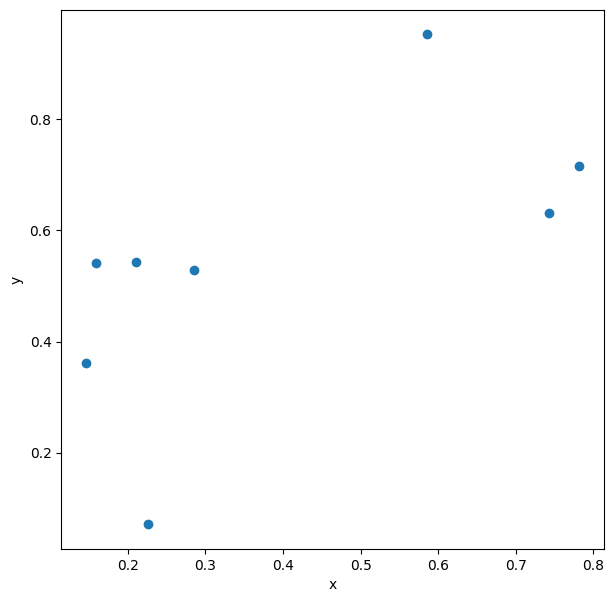

In [4]:
show_plot(locations)

## 組合せ最適化モデルの構築
巡回セールスマン問題の定式化。
$(N+1) \times N$ のバイナリ変数で、$q[i,j]$ 都市のインデックス $i$、巡回順のインデックス $j$。

In [5]:
from amplify import VariableGenerator

gen = VariableGenerator()
q = gen.array("Binary", shape=(NUM_CITIES + 1, NUM_CITIES))
q[NUM_CITIES, :] = q[0, :]  # 最初の都市と最後の都市は同じ。この固定はコスト関数、制約関数の定義より前に行う
    
print(q)

[[q_{0,0}, q_{0,1}, q_{0,2}, q_{0,3}, q_{0,4}, q_{0,5}, q_{0,6}, q_{0,7}],
 [q_{1,0}, q_{1,1}, q_{1,2}, q_{1,3}, q_{1,4}, q_{1,5}, q_{1,6}, q_{1,7}],
 [q_{2,0}, q_{2,1}, q_{2,2}, q_{2,3}, q_{2,4}, q_{2,5}, q_{2,6}, q_{2,7}],
 [q_{3,0}, q_{3,1}, q_{3,2}, q_{3,3}, q_{3,4}, q_{3,5}, q_{3,6}, q_{3,7}],
 [q_{4,0}, q_{4,1}, q_{4,2}, q_{4,3}, q_{4,4}, q_{4,5}, q_{4,6}, q_{4,7}],
 [q_{5,0}, q_{5,1}, q_{5,2}, q_{5,3}, q_{5,4}, q_{5,5}, q_{5,6}, q_{5,7}],
 [q_{6,0}, q_{6,1}, q_{6,2}, q_{6,3}, q_{6,4}, q_{6,5}, q_{6,6}, q_{6,7}],
 [q_{7,0}, q_{7,1}, q_{7,2}, q_{7,3}, q_{7,4}, q_{7,5}, q_{7,6}, q_{7,7}],
 [q_{0,0}, q_{0,1}, q_{0,2}, q_{0,3}, q_{0,4}, q_{0,5}, q_{0,6}, q_{0,7}]]


コスト関数における和の演算に対して einsum 関数を使用する。
- $q[:-1]$ は $q$ の最後の行を除いた $N \times N$ 部分 -> $q^U$
- $q[1:]$ は $q$ の最初の行を除いた $N \times N$ 部分 -> $q^D$
これらを用いて、
$$
 \sum_{n=0}^{N-1} \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} d_{i,j} q_{n,i} q_{n+1,j} = \sum_{n,i,j} d_{i,j} q_{n,i}^{U} q_{n,j}^{D}
$$

In [6]:
from amplify import einsum, Poly
    
objective: Poly = einsum("ij,ni,nj->", distances, q[:-1], q[1:])  # type: ignore

In [ ]:
from amplify import sum as amplify_sum
    
cost = amplify_sum(
    range(NUM_CITIES),
    lambda n: amplify_sum(
        range(NUM_CITIES),
        lambda i: amplify_sum(
            range(NUM_CITIES), lambda j: distances[i, j] * q[n, i] * q[n + 1, j]
        ),
    ),
)

制約条件構築

In [ ]:
from amplify import one_hot
    
# 最後の行を除いた q の各行のうち一つのみが 1 である制約
row_constraints = one_hot(q[:-1], axis=1)
    
# 最後の行を除いた q の各列のうち一つのみが 1 である制約
col_constraints = one_hot(q[:-1], axis=0)
    
constraints = row_constraints + col_constraints

In [7]:
r_const = 0
for i in range(NUM_CITIES):
    temp = 0.0
    for j in range(NUM_CITIES):
        temp += q[i,j]
    r_const += (1.0 - temp) ** 2

c_const = 0
for j in range(NUM_CITIES):
    temp = 0.0
    for i in range(NUM_CITIES):
        temp += q[i,j]
    c_const += (1.0 - temp) ** 2

print(r_const)
print(c_const)

constraints = r_const + c_const

2 q_{0,0} q_{0,1} + 2 q_{0,0} q_{0,2} + 2 q_{0,0} q_{0,3} + 2 q_{0,0} q_{0,4} + 2 q_{0,0} q_{0,5} + 2 q_{0,0} q_{0,6} + 2 q_{0,0} q_{0,7} + 2 q_{0,1} q_{0,2} + 2 q_{0,1} q_{0,3} + 2 q_{0,1} q_{0,4} + 2 q_{0,1} q_{0,5} + 2 q_{0,1} q_{0,6} + 2 q_{0,1} q_{0,7} + 2 q_{0,2} q_{0,3} + 2 q_{0,2} q_{0,4} + 2 q_{0,2} q_{0,5} + 2 q_{0,2} q_{0,6} + 2 q_{0,2} q_{0,7} + 2 q_{0,3} q_{0,4} + 2 q_{0,3} q_{0,5} + 2 q_{0,3} q_{0,6} + 2 q_{0,3} q_{0,7} + 2 q_{0,4} q_{0,5} + 2 q_{0,4} q_{0,6} + 2 q_{0,4} q_{0,7} + 2 q_{0,5} q_{0,6} + 2 q_{0,5} q_{0,7} + 2 q_{0,6} q_{0,7} + 2 q_{1,0} q_{1,1} + 2 q_{1,0} q_{1,2} + 2 q_{1,0} q_{1,3} + 2 q_{1,0} q_{1,4} + 2 q_{1,0} q_{1,5} + 2 q_{1,0} q_{1,6} + 2 q_{1,0} q_{1,7} + 2 q_{1,1} q_{1,2} + 2 q_{1,1} q_{1,3} + 2 q_{1,1} q_{1,4} + 2 q_{1,1} q_{1,5} + 2 q_{1,1} q_{1,6} + 2 q_{1,1} q_{1,7} + 2 q_{1,2} q_{1,3} + 2 q_{1,2} q_{1,4} + 2 q_{1,2} q_{1,5} + 2 q_{1,2} q_{1,6} + 2 q_{1,2} q_{1,7} + 2 q_{1,3} q_{1,4} + 2 q_{1,3} q_{1,5} + 2 q_{1,3} q_{1,6} + 2 q_{1,3} q_{1,7} + 

コスト関数を作成し、制約と合わせてモデルを生成

In [8]:
constraints *= np.amax(distances)  # 制約条件の強さを設定
model = objective + constraints
# model = cost + constraints

イジングマシン実行

In [9]:
from datetime import timedelta
from amplify import FixstarsClient, solve
from datetime import timedelta
    
    
client = FixstarsClient()
client.token = "AE/uoJdkjxByNhoLWqMYIpjf2uIl2SUOi8m"  
client.parameters.timeout = timedelta(milliseconds=1000)  # タイムアウト 1000 ミリ秒
    
# ソルバーの設定と結果の取得
result = solve(model, client)
if len(result) == 0:
    raise RuntimeError("At least one of the constraints is not satisfied.")

In [10]:
result.best.objective

2.292261938139281

In [11]:
q_values =q.evaluate(result.best.values)

route = np.where(q_values[:-1] == 1)[1]
print(route)
# print(len(route))

[1 4 0 2 6 3 7 5]


In [12]:
def show_route(route: np.ndarray, distances: np.ndarray, locations: np.ndarray):
    path_length = sum([distances[route[i]][route[(i + 1) % NUM_CITIES]] for i in range(NUM_CITIES)])
    
    x = [i[0] for i in locations]
    y = [i[1] for i in locations]
    plt.figure(figsize=(7, 7))
    plt.title(f"path length: {path_length}")
    plt.xlabel("x")
    plt.ylabel("y")
    
    for i in range(NUM_CITIES):
        r = route[i]
        n = route[(i + 1) % NUM_CITIES]
        plt.plot([x[r], x[n]], [y[r], y[n]], "b-")
    plt.plot(x, y, "ro")
    plt.show()
    
    return path_length

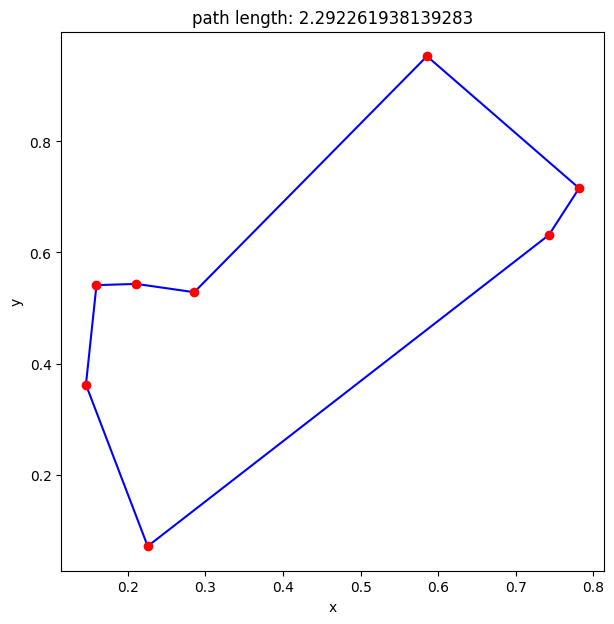

np.float64(2.292261938139283)

In [13]:
show_route(route, distances, locations)